This script is for calculating the specific surface area ($S_{BET}$) of a solid sample, including error from Inverse Gas Chromatography measurements, specifically those done on the SEA (Surface energy analyser). Measured parameters are imported from a csv file and the specific surface area of the sample is printed at the end of the document along with visualisations of the adsorption isotherm and BET plot.

In [31]:
import pandas as pd
import numpy as np
from pandas import Series,DataFrame
from scipy import stats, constants
import matplotlib.pyplot as plt
%matplotlib inline

# Organising data

In [32]:
# Reads csv input file and skips rows to where data start
input_file = raw_input('Copy path to input file here \nmake sure to insert extra "\\" and remove "" \n')
df = pd.read_csv(input_file, skiprows = 17)

Copy path to input file here 
make sure to insert extra "\" and remove "" 
C:\\Users\\tcd\\Dropbox\\Graphite study\\Surface area error calcs\\5-timcal.csv


In [33]:
# Removing of solvents that arent used in calculation
df= df[(df.Solvent != 'n/a') & (df.Solvent != 'Methane')]
df

,ID,Injection Name,Solvent,Injection Time [ms],Duration [min],Target Fractional Surface Coverage,Actual Fractional Surface Coverage,Column Temperature [Kelvin],Column Pressure Drop [Torr],Exit Flow Rate [sccm],...,Net Ret Volume (Max) [ml/g],Net Ret Time (Com) [min],Net Ret Volume (Com) [ml/g],Partial Pressure [Torr],Pres Ret Volume (Max) [mMol/(g�Torr)],Pres Ret Volume (Com) [mMol/(g�Torr)],Amount [mMol/g],Amount [mMol],Amount (Max) [mMol/g],Amount (Com) [mMol/g]
2,3,injection1,OCTANE,690,10,0.01,0.008082,293.160885,48.527700,19.995001,...,44.465924,0.096308,109.408216,0.275066,0.002432,0.005984,0.000746,0.000014,0.000669,0.001646
3,4,injection2,OCTANE,1352,8,0.02,0.017646,293.172950,48.556311,19.995001,...,46.360724,0.067522,76.708129,0.724134,0.002536,0.004195,0.001628,0.000030,0.001808,0.003530
4,5,injection3,OCTANE,1987,7,0.03,0.027795,293.154620,49.386089,20.009999,...,46.367575,0.061739,70.149506,1.216179,0.002536,0.003837,0.002564,0.000047,0.003056,0.005418
5,6,injection4,OCTANE,2597,6,0.04,0.040427,293.165016,48.913980,19.997499,...,50.140428,0.057482,65.293807,1.812108,0.002742,0.003571,0.003729,0.000068,0.004690,0.007546
6,7,injection5,OCTANE,3182,4,0.05,0.052291,292.967055,49.657915,19.990000,...,51.972344,0.056923,64.559173,2.355512,0.002845,0.003534,0.004824,0.000088,0.006236,0.009466
7,8,injection6,OCTANE,3743,1,0.06,0.062146,292.687175,49.343168,20.002501,...,61.397387,0.059771,67.780736,2.617697,0.003364,0.003713,0.005733,0.000105,0.007118,0.010440
8,9,injection7,OCTANE,4282,1,0.07,0.077337,292.676995,50.902580,19.992500,...,66.982930,0.060867,68.916645,3.076822,0.003670,0.003776,0.007134,0.000131,0.008802,0.012174
9,10,injection8,OCTANE,4801,1,0.08,0.087591,292.701290,50.831055,20.000000,...,68.885905,0.061669,69.860305,3.367961,0.003774,0.003827,0.008080,0.000148,0.009901,0.013288
10,11,injection9,OCTANE,5299,1,0.09,0.101905,292.731675,51.546375,19.992499,...,74.495198,0.064532,73.050307,3.731230,0.004081,0.004001,0.009401,0.000172,0.011384,0.014741
11,12,injection10,OCTANE,5780,1,0.1,0.109541,292.788705,49.486235,20.002500,...,78.427491,0.066655,75.606421,3.864324,0.004295,0.004141,0.010105,0.000185,0.011955,0.015293


In [34]:
# Renaming columns with funny character
df.rename(columns ={'Peak Area [\xb5V\x95min]': 'peak_area', 'Peak Max (Signal) [\xb5V]': 'peak_max_signal'},inplace=True)

# Removing unwanted rows
df = df[df.peak_area != 0]

#  James-Martin pressure correction, j

$$j=\frac{3}{2}\frac{(\frac{p_{in}}{p_{out}})^{2}-1}{(\frac{p_{in}}{p_{out}})^{3}-1}$$

In [35]:
# Atmospheric pressure in torr
p_out = 760

# input pressure is pressure drop + atomospheric pressure
p_in = df['Column Pressure Drop [Torr]'] + p_out

j = (1.5*(((p_in/p_out)**2 -1)/((p_in/p_out)**3 -1)))

# Net Retention Volume, Vn ($\frac{mL}{g}$)

$$V_{N}=\frac{j}{m}F(t_{r}-t_{0})(\frac{T}{273.15})$$

In [36]:
# Creating input for sample mass and change its units
m_df = pd.read_csv(input_file,nrows=1,header=None,skiprows=4)
m=float(m_df.ix[:,1:1].values.flatten())
m = m / 1000 # mg to g

vn = (j * df['Exit Flow Rate [sccm]'] * df['Net Ret Time (Max) [min]'] * df['Column Temperature [Kelvin]'] ) / (m * 273.15)

# Partial pressure, p (Pa)

$$p=\frac{n_{i}RH_{peak}273.15}{FA_{peak}}$$

In [37]:
A_peak = df['peak_area']
n_i = df['Amount  [mMol]']
H_peak = df['peak_max_signal']
F = df['Exit Flow Rate [sccm]']

In [38]:
# Converting units to SI

vn_SI = vn * 0.001 # converts mg/L to m^3/kg
A_peak = A_peak * 6E-5 #converts uV.min to V.sec
n_i = n_i / 1000 # converts mMol to Mol
H_peak = H_peak * 1E-6 # converts uV to V
F = F * 1.6667E-8 #from sscm to m^3/s

In [39]:
# Gas constant
R = constants.R

In [40]:
p = (n_i * R * 273.15 * H_peak) / (F * A_peak) # Pa

#  Amount of probe adsorbed on sample surface, n, ($\frac{mMol}{g}$)

$$n=\frac{1}{RT}\intop_{0}^{p}V_{n}dp$$

In [41]:
# Reindexing series to start at zero
p_reindex = p.reset_index(drop=True)
vn_SI_reindex = vn_SI.reset_index(drop=True)

In [42]:
# T value used in n calc
T_av = df['Column Temperature [Kelvin]'].mean()

In [43]:
# set n as empty array in shape of as other values 
n = np.empty_like(p_reindex)

In [44]:
# Cumulative integration  of vn with respect to partial pressure p
n[0] = (p_reindex[0] * vn_SI_reindex[0]) / (R * T_av)
for i in range(1, len(p_reindex)):
    n[i] = (p_reindex[i] - p_reindex[i - 1]) * (vn_SI_reindex[i] / (R * T_av)) + n[i - 1]

In [45]:
# set n as series with same index as p_reindex and vn_SI_reindex
n = Series(n)

# Saturation vapour pressure calculation, $p_{sat}$ (Pa)

$$\log_{10}p_{sat}=A-\frac{B}{C+T}$$
$$p_{sat}=10^{(A-\frac{B}{C+T})}$$

In [46]:
# Antoine coefficients for octane (probe used for surface area calculations from AntoineConstants excel file)

In [47]:
# Coefficents A,B,C are for T = 20C
A = 6.91868
B = 1351.99
C = 209.155


p_sat = 10 ** (A- (B /(20+C))) # mmHg T= 20C
p_sat = p_sat * 133.322 # mmHg to Pa

# Relative pressure, $p_{rel}$

$$p_{rel}=\frac{p}{p_{sat}}$$

In [48]:
p_rel = p_reindex / p_sat

# Adsorption Isotherm Plot

(0, 0.40706967560702112)

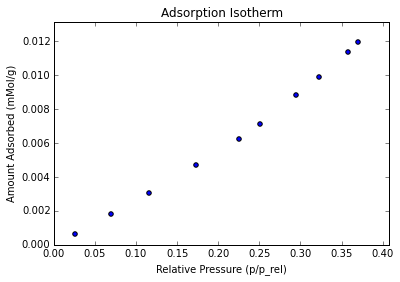

In [49]:
plt.scatter(p_rel, n)
plt.title('Adsorption Isotherm')
plt.xlabel('Relative Pressure (p/p_rel)')
plt.ylabel('Amount Adsorbed (mMol/g)')
x_max = max(p_rel) + (0.1 * max(p_rel))
y_max = max(n) + (0.1 * max(n))
plt.ylim(0,y_max)
plt.xlim(0,x_max)

#  BET  equation plot and calculation

$$\frac{p}{n(p-p_{sat})}=\frac{C-1}{n_{m}C}\frac{p}{p_{sat}}+\frac{1}{n_{m}C}$$

In [50]:
# setting Y axis for BET plot
y_BET = p_reindex / (n * (p_sat - p_reindex))

In [51]:
# set up BET dataframe
BET_df = pd.concat([p_rel, y_BET], axis = 1)
BET_df.columns = ['p_rel', 'y_BET']

In [52]:
# BET equation is only valid between p_rel values of 0.05 to 0.35
BET_df = BET_df[(BET_df.p_rel >= 0.05) & (BET_df.p_rel <= 0.35)]

In [53]:
BET_df

,p_rel,y_BET
1,0.069370,41.184996
2,0.116405,43.101090
3,0.173409,44.727748
4,0.225629,46.681293
5,0.250682,46.980616
6,0.294650,47.446113
7,0.322530,48.078038


In [54]:
# Function does linear regression and if threshold r_sq values isnt reached it removes the first row of dataframe
# First row is removed because generally BET data is better at higher p_rel
def regress(df):
    # Linear regression of BET plot within allowed p_rel range
    slope, intercept, r_value, p_value, std_err = stats.linregress(df['p_rel'],df['y_BET'])
    
    r_sq = r_value ** 2
    print 'The R square value is %f.4' % r_sq
    
    if r_sq < 0.984:
        
        return regress(df.iloc[:-1, :]) # re-runs function with first row removed, removes last row until threshold r_sq reached
    else:
        # Calculations used for finding error in intercept from 'https://en.wikipedia.org/wiki/Regression_analysis'
        sse = ((df['y_BET'] - ((slope * df['p_rel']) + intercept)) ** 2).sum()
        n = len(df['p_rel'])
        var = np.sqrt((sse / (n - 2)))
        x_mean = df['p_rel'].mean()
        sx2 = ((df['p_rel'] - x_mean) **2).sum()
        intercept_err = var * np.sqrt((1/n) + (x_mean ** 2) / sx2)
        
        return slope,intercept,r_value,p_value,std_err,r_sq, intercept_err

In [55]:
slope,intercept,r_value,p_value, std_err, r_sq,intercept_err = regress(BET_df)

The R square value is 0.964674.4
The R square value is 0.968170.4
The R square value is 0.991270.4


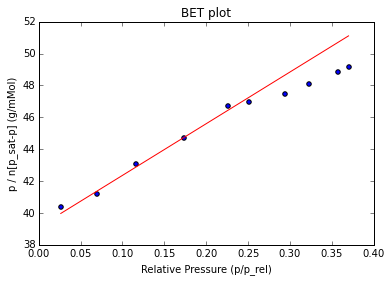

In [56]:
# BET plot
plt.scatter(p_rel,y_BET)
plt.plot(p_rel, (p_rel * slope) + intercept, c='r')
plt.title('BET plot')
plt.xlabel('Relative Pressure (p/p_rel)')
plt.ylabel('p / n[p_sat-p] (g/mMol)')


$$n_{m}=\frac{1}{slope+intercept}$$

In [57]:
# The monolayer capacity, n_m is found from slope and intercept of fitted line from BET plot

n_m = 1 / (slope + intercept) # mMol/g
err_slope_intercept = np.sqrt((std_err) ** 2 + (intercept_err) ** 2) # error in slope+intercept
n_m_err = n_m * (err_slope_intercept / (slope + intercept)) # error in n_m
n_m = n_m / 1000 # change units from mMol/g to Mol/g
n_m_err = n_m_err / 1000 # change units from mMol/g to Mol/g

#  Specific Surface Area, $\frac{m^{2}}{g}$

$$S_{BET}=n_{m}N_{a}a$$

In [58]:
a = 6.3E-19 # m^2 This is the cross-sectional surface area of a Octane molecule
Na = constants.Avogadro

In [59]:
ssa = n_m * Na * a
ssa_err = ssa * (n_m_err / n_m)

In [60]:
print 'The SSA is %.2f with error %.2f and R^2 of %.4f' % (ssa,ssa_err,r_sq)

The SSA is 5.30 with error 0.13 and R^2 of 0.9913
